<h2>Generative Adversarial Nets - generate 1-D Gaussian distribution</h2>
<p>Original GAN paper: <a href='https://arxiv.org/pdf/1406.2661v1.pdf'>https://arxiv.org/pdf/1406.2661v1.pdf</a></p>
<p>This code is borrowed from and modified based on Eric Jang's implementation: <a href='http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html'>http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html</a></p>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
from scipy.stats import norm

/Applications/Spyder-Py2.app/Contents/Resources/lib/python2.7/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Network config

In [3]:
tf.reset_default_graph()
np.random.seed(1) 
tf.set_random_seed(1)

# config
mu = 2 # mean for true data distribution
std = 1 # # std for true data distribution
nodes_per_layer = [5, 5, 1] # [2nd 3rd, 4th... layer]
training_epochs = 15001
batch_size = 200
alpha = 0.001 # base learning rate
decay_rate = 0.95 # exponential decay rate for learning rate
momentum = 0.6 # the fraction factor
k = 5 # this is number of times to update discriminator for every time generator is updated in each epoch
logs_path = "/tmp/gan_gaussian"

### Draw true data distribution
#### We are trying to let our generator to fit the guassian distribution with mean=2 and std=1

This is what the true distribution looks like:


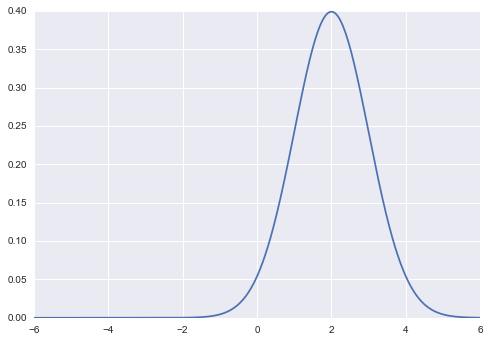

In [4]:
x = np.linspace(-6,6,1000)
y = norm.pdf(x, loc = mu, scale = std)
plt.plot(x, y)
print 'This is what the true distribution looks like:'

### Function that creates a multi-layer perceptron and outputs a probabiliy value, will be used for both the generator and the discriminator

In [5]:
def mlp(input_nodes, nodes_per_layer):
    num_nodes_2nd_layer = nodes_per_layer[0]
    num_nodes_3rd_layer = nodes_per_layer[1]
    num_nodes_output_layer = nodes_per_layer[2]
    # parameters connecting 1st and 2nd layers. 
    w1 = tf.get_variable('w1', shape=[input_nodes.get_shape()[1],num_nodes_2nd_layer], initializer=tf.random_normal_initializer())
    b1 = tf.get_variable('b1', shape=[num_nodes_2nd_layer], initializer=tf.constant_initializer(0.0))
    
    # parameters connecting 2nd and 3rd layers. 
    w2 = tf.get_variable('w2', shape=[num_nodes_2nd_layer,num_nodes_3rd_layer], initializer=tf.random_normal_initializer())
    b2 = tf.get_variable('b2', shape=[num_nodes_3rd_layer], initializer=tf.constant_initializer(0.0))
    
    # parameters connecting 3rd and output layers. 
    w3 = tf.get_variable('w3', shape=[num_nodes_3rd_layer,num_nodes_output_layer], initializer=tf.random_normal_initializer())
    b3 = tf.get_variable('b3', shape=[num_nodes_output_layer], initializer=tf.constant_initializer(0.0))
    
    fc1 = tf.nn.tanh(tf.matmul(input_nodes,w1)+b1)
    fc2 = tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    output_nodes = tf.nn.tanh(tf.matmul(fc2,w3)+b3) # output ranges from [-1, 1]
    return output_nodes, [w1,b1,w2,b2,w3,b3]

### Function that returns the operation for momentum parameter updates

In [6]:
def momentum_optimizer(loss, alpha, training_epochs, decay_rate, momentum, var_list):
    epoch = tf.Variable(0)
    # lower the learning rate as the training progresses
    learning_rate = tf.train.exponential_decay(
        learning_rate = alpha, # base learning rate
        global_step = epoch,  # current batch into the dataset
        decay_steps = training_epochs/4, # decays 4 times throughout training process.
        decay_rate = decay_rate,
        staircase=True)
    optimizer=tf.train.MomentumOptimizer(learning_rate, momentum).minimize(loss, global_step=epoch, var_list=var_list)
    return optimizer # return the optimizer operation

## Optional - below
### Pre-train Decision Surface

In [ ]:
# plot true data distribution and the pre-trained decision surface for discriminator
def plot_d(D,input_node):
    f,ax=plt.subplots(1)
    # plot true data distribution
    x=np.linspace(-6,6,1000)
    ax.plot(x, norm.pdf(x,loc=mu,scale=std), label='p_data')
    
    # decision boundary
    r=1000 # resolution (number of points)
    M=batch_size
    x=np.linspace(-6,6,r)
    ds=np.zeros((r,1)) # decision surface
    
    # process multiple points in parallel in a minibatch
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        # process multiple x samples using mini-batch
        for i in range(r/M):
            x_reshaped=np.reshape(x[M*i:M*(i+1)],(M,1))
            ds[M*i:M*(i+1)]=sess.run(D,{input_node: x_reshaped})

        ax.plot(x, ds, label='decision boundary')
        ax.set_ylim(0,1.1)
        plt.legend()

In [ ]:
# Set up the discriminator and its training mechnism
with tf.variable_scope("D_pre_training", reuse=True):
    input_node=tf.placeholder(tf.float32, shape=(batch_size,1))
    train_labels=tf.placeholder(tf.float32,shape=(batch_size,1))
    D,theta=mlp(input_node,nodes_per_layer)
    loss=tf.reduce_mean(tf.square(D-train_labels))
    #optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(loss)
    optimizer = momentum_optimizer(loss, alpha, training_epochs, decay_rate, momentum, None)

In [ ]:
# creat discriminator and plot the pre-trained decision boundary
plot_d(D,input_node)
plt.title('Initial Decision Boundary')

In [ ]:
# train the discriminator
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())

    num_pre_train_epochs = 1001
    d_loss_holder=np.zeros(num_pre_train_epochs)
    for epoch in range(num_pre_train_epochs):
        #x = (np.random.random(batch_size)-0.5) * 12.0 # instead of sampling only from gaussian, want the domain to be covered as uniformly as possible
        x = np.random.normal(mu,std,batch_size) 
        x = np.reshape(x,(batch_size,1))
        
        labels=norm.pdf(x,loc=mu,scale=std) 
        labels = np.reshape(x,(batch_size,1))
        d_loss_holder[epoch],_=sess.run([loss,optimizer], {input_node: x, train_labels: labels})

        if epoch % 200 == 0:
            print 'epoch: ', epoch

# plot training loss over epochs
plt.plot(d_loss_holder)
plt.title('Training Loss')

# plot true data distribution and after-trained decision surface
plot_d(D,input_node)

## Optional - above

In [7]:
# plots true data distribution, generated data distribution and decision boundary 
def plot_fig():
    f,ax=plt.subplots(1)
    
    # plot true data distribution
    x=np.linspace(-6,6,1000)
    ax.plot(x, norm.pdf(x,loc=mu,scale=std), label='true_distribution')

    # plot decision boundary
    r=1000 # resolution (number of points)
    x=np.linspace(-6,6,r)
    ds=np.zeros((r,1)) # placeholder for decision surface
    
    # process multiple points in parallel in same minibatch
    for i in range(r/batch_size):
        x_reshaped = np.reshape(x[batch_size*i:batch_size*(i+1)],(batch_size,1))

        # get predicted probability by feeding real samples to discriminator
        ds[batch_size*i:batch_size*(i+1)]=sess.run(d_output_x,{x_vector: x_reshaped})
    ax.plot(x, ds, label='decision boundary')

    # plot generated samples
    z=np.linspace(-6,6,r) # stratified sampling
    gs=np.zeros((r,1)) # placeholder for generated samples

    # process multiple points in parallel in same minibatch
    for i in range(r/batch_size):
        z_reshaped=np.reshape(z[batch_size*i:batch_size*(i+1)],(batch_size,1))

        # get generated samples by feeding noise to generator
        gs[batch_size*i:batch_size*(i+1)]=sess.run(g_output,{z_vector: z_reshaped})
    
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-6,6,10), histc/float(r), label='generated_distribution')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()

## Building the generative adversarial net

In [8]:
# create the generator network that takes a noise input and outputs a generated sample
with tf.variable_scope('generator'):
    z_vector = tf.placeholder(tf.float32, shape=[batch_size,1]) # placeholder for initial z noise vector
    g_output, para_g = mlp(z_vector, nodes_per_layer) # feed z_vector to generator and return the generated sample, which is [-1,1]
    g_output = tf.mul(6.0, g_output) # scale up the range to [-6, 6]

# reuse=True creates another copy of the discriminator networks that share parameters, since TF doesn't allow feeding 
# two different inputs to one netowrk
# One will be used to evaluate samples from true distribution
# Another one will be used to evaluate samples from generator's learned distribution
with tf.variable_scope('discriminator') as scope:
    x_vector = tf.placeholder(tf.float32, shape=[batch_size,1]) # placeholder for data samples from true distribution
    
    # feed x_vector to discriminator and output an estimated probability, ranges from [-1,1]
    d_output_x, para_d = mlp(x_vector, nodes_per_layer) 
    d_output_x=tf.maximum(tf.minimum(d_output_x, 0.99), 0.01) # avoid inf and -inf
    
    # make a copy of discriminator network with the same parameters
    scope.reuse_variables()
    
    # feed the generated sample to discriminator and output an estimated probability, ranges from [-1,1]
    d_output_z, para_d = mlp(g_output, nodes_per_layer) 
    d_output_z=tf.maximum(tf.minimum(d_output_z, 0.99), 0.01) # avoid inf and -inf

d_loss = 1 - tf.reduce_mean(tf.log(d_output_x) + tf.log(1-d_output_z)) # loss for discriminator
summary_d_loss = tf.scalar_summary("d_loss", d_loss)

g_loss = 1 - tf.reduce_mean(tf.log(d_output_z)) # loss for generator
summary_g_loss = tf.scalar_summary("g_loss", g_loss)

# update parameters to optimize the generator and discriminator, respectively
optimizer_op_d = momentum_optimizer(d_loss, alpha, training_epochs, decay_rate, momentum, para_d) # only update para_d
optimizer_op_g = momentum_optimizer(g_loss, alpha, training_epochs, decay_rate, momentum, para_g) # only update para_g

In [9]:
sess=tf.InteractiveSession() # launch graph
tf.initialize_all_variables().run() # initialize variables before we can use them, just do this once

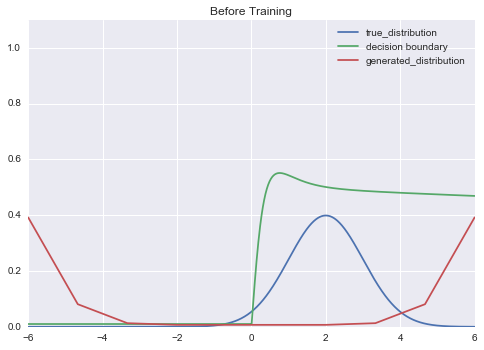

In [10]:
plot_fig()
plt.title('Before Training')

## Train the GAN model

In [11]:
# create a log folder and save the graph structure, do this before training
g_writer = tf.train.SummaryWriter(logs_path + '/generator', graph=tf.get_default_graph())
d_writer = tf.train.SummaryWriter(logs_path + '/discriminator')

# perform training cycles
for epoch in range(training_epochs):
    # mini-batch samples from true distribution
    x = np.random.normal(mu,std,batch_size) 
    x.sort() # sort x samples so that z is aligned 
    x = np.reshape(x,(batch_size,1))

    # mini-batch of noise data, use linspace here as stratified sampling, in order to align with the sorted x
    z = np.linspace(-6,6,batch_size) + np.random.random(batch_size) * 0.01 
    z = np.reshape(z,(batch_size,1))
    
    # update discriminator k times for every time generator gets updated
    for i in range(k):
        summary_d, d_loss_print, _ = sess.run([summary_d_loss, d_loss, optimizer_op_d], feed_dict={x_vector: x, z_vector: z})

    # update generator
    summary_g, g_loss_print, _ = sess.run([summary_g_loss, g_loss, optimizer_op_g], feed_dict={z_vector: z})

    if epoch % 50 == 0:
        d_writer.add_summary(summary_d, epoch) # add loss summary to tensorboard
        g_writer.add_summary(summary_g, epoch)

    if epoch % 1000 == 0:
        print 'step:',epoch,
        print ' D loss:', d_loss_print,
        print ' G loss:', g_loss_print

        # Debug utilities..
        #print ' D loss_x:',sess.run(x_loss,feed_dict={x_vector: x}),
        #print ' D loss_z:',sess.run(z_loss,feed_dict={z_vector: z})
        #print ' D output x:',sess.run(d_output_x,feed_dict={x_vector: x})
        #print ' D output z:',sess.run(d_output_z,feed_dict={z_vector: z})
        #print ' G output:',sess.run(g_output,feed_dict={z_vector: z})
        #print ' D loss:', sess.run([d_loss, optimizer_op_d],feed_dict={x_vector: x, z_vector: z})[0],
        #print ' G loss:', sess.run([g_loss, optimizer_op_g],feed_dict={z_vector: z})[0]
        #print ' D parameters:', sess.run(para_d)
        #print ' G parameters:', sess.run(para_g),'\n'

step: 0  D loss: 2.09228  G loss: 3.64472
step: 1000  D loss: 2.39461  G loss: 1.69387
step: 2000  D loss: 2.38518  G loss: 1.6954
step: 3000  D loss: 2.38556  G loss: 1.70015
step: 4000  D loss: 2.3788  G loss: 1.70508
step: 5000  D loss: 2.38274  G loss: 1.70305
step: 6000  D loss: 2.38273  G loss: 1.71206
step: 7000  D loss: 2.41867  G loss: 1.68743
step: 8000  D loss: 2.37744  G loss: 1.70931
step: 9000  D loss: 2.38543  G loss: 1.67956
step: 10000  D loss: 2.38672  G loss: 1.69299
step: 11000  D loss: 2.38739  G loss: 1.69513
step: 12000  D loss: 2.3909  G loss: 1.68547
step: 13000  D loss: 2.38594  G loss: 1.69919
step: 14000  D loss: 2.38678  G loss: 1.68673
step: 15000  D loss: 2.38166  G loss: 1.67915


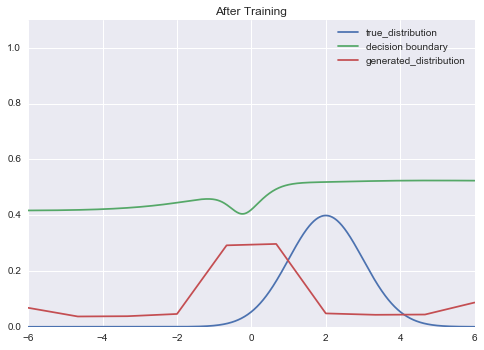

In [12]:
plot_fig()
plt.title('After Training')

### We can see the generated samples (red) are kinda mimicking the true data distribution (blue), and the decision boundary starts confounding about the two